# Implementing a Quantum Fourier Transform (QFT)
In this example we want to bring everything together to efficiently calculate filter functions of a QFT. We will optimize atomic gates using QuTiP and set up `PulseSequence`s with the optimized parameters. Using those, we will assemble a QFT circuit with interactions limited to nearest neighbors, thus requiring us to swap qubits around the registers to perform controlled rotations.

The circuit for the algorithm on four qubits is as follows (for simplicity we run the transformations of each qubit sequentially):

![qft.png](../_static/qft.png)

Here, unlike in the canonical circuit ([Wikipedia](https://en.wikipedia.org/wiki/Quantum_Fourier_transform#Circuit_implementation)), the qubits are already swapped when the algorithm finishes.

## Physical model
We will consider a qubit model where single-qubit operations are performed using I-Q manipulation and two-qubit operations using nearest-neighbor exchange interaction. Concretely, the single-qubit control Hamiltonian is given by

$$
H_c^{(1)}(t) = I(t)\:\sigma_x + Q(t)\:\sigma_y
$$

and the two-qubit control Hamiltonian by

$$
H_c^{(2)}(t) = I_1(t)\; \sigma_x \otimes \mathbb{1} + Q_1(t)\;\sigma_y \otimes \mathbb{1} + J(t)\:\sigma_z \otimes \sigma_z + I_2(t)\; \mathbb{1} \otimes \sigma_x + Q_2(t)\;\mathbb{1} \otimes \sigma_y.
$$

## Optimizing pulses using GRAPE
We would like to keep the size of our optimized gate set as small as possible and thus compile the required gates from the set $\left\lbrace\mathrm{X(\pi/2)}, \mathrm{Y(\pi/2)}, \mathrm{CZ(\pi/2^4)}\right\rbrace$ for a four-qubit QFT.

In [1]:
import numpy as np
import qutip as qt
from qutip.control import pulseoptim
from qutip.qip import operations

import filter_functions as ff

np.random.seed(10)
n_qubits = 4
# Single-qubit control Hamiltonian
H_c_single = [
    qt.sigmax(),
    qt.sigmay()
]
# Initial unitary
U_0_single = qt.qeye(2)
# No constant terms
H_d_single = U_0_single*0

# Two-qubit control Hamiltonian
H_c_two = [
    qt.tensor(qt.sigmax(), qt.qeye(2)),
    qt.tensor(qt.sigmay(), qt.qeye(2)),
    qt.tensor(qt.qeye(2), qt.sigmax()),
    qt.tensor(qt.qeye(2), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz())
]
# Initial unitary
U_0_two = qt.tensor(qt.qeye(2), qt.qeye(2))
# No constant terms
H_d_two = U_0_two*0

# Define the target unitaries
target_gates = {
    'X_pi2': operations.rotation(qt.sigmax(), np.pi/2),
    'Y_pi2': operations.rotation(qt.sigmay(), np.pi/2),
    'CZ_pi16': operations.cphase(np.pi/2**n_qubits) 
}
H_c = {
    'X_pi2': H_c_single,
    'Y_pi2': H_c_single,
    'CZ_pi16': H_c_two,
}
H_d = {
    'X_pi2': H_d_single,
    'Y_pi2': H_d_single,
    'CZ_pi16': H_d_two,
}
U_0 = {
    'X_pi2': U_0_single,
    'Y_pi2': U_0_single,
    'CZ_pi16': U_0_two,    
}

# Define some optimization parameters
t_sample = 1
n_sample = 30
t_clock = t_sample*n_sample

optim_options = dict(
    alg='GRAPE',                          # algorithm (could also do CRAB)
    num_tslots=n_sample,                  # number of time steps
    evo_time=t_clock,                     # total evolution time
    amp_lbound=0,                         # amplitudes should be positive
    fid_err_targ=1e-12,                   # target overlap
    max_iter=10**5,                       # maximum number of iterations
    init_pulse_type='RND',                # initial amplitude shapes
    init_pulse_params=dict(num_waves=2),  # number of wavelengths of init pulse
    phase_option='PSU',                   # ignore global phase
    method_params=dict(tol=1e-10),        # tolerance
)

grape_results = {
    name: pulseoptim.optimize_pulse_unitary(
        H_d=H_d[name],
        H_c=H_c[name],
        U_0=U_0[name],
        U_targ=target,
        **optim_options
    ) for name, target in target_gates.items()
}

With the pulses optimized, we can now set up the `PulseSequence`s for each and assert their correct action:

X_pi2 	: (True, -3.141592653589793)
Y_pi2 	: (True, 3.141592653589793)
CZ_pi16 	: (True, -1.5217089415825558)


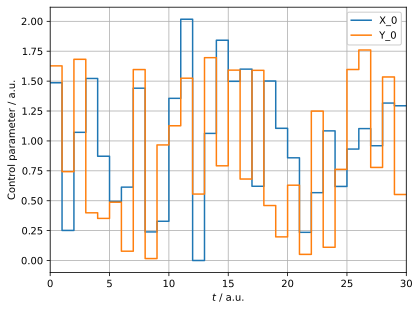

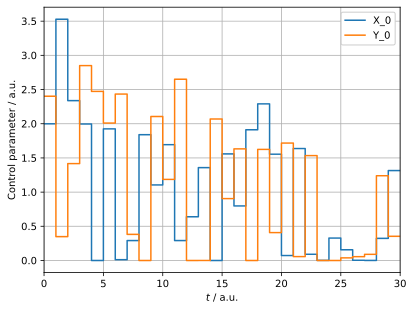

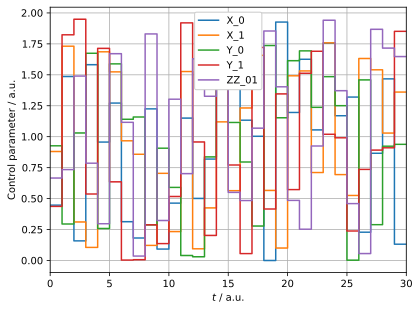

In [2]:
from filter_functions import plotting

identifiers = {
    'X_pi2': ['X_0', 'Y_0'],
    'Y_pi2': ['X_0', 'Y_0'],
    'CZ_pi16': ['X_0', 'Y_0', 'X_1', 'Y_1', 'ZZ_01']
}
pulses = {}
for name, result in grape_results.items():
    pulse = ff.PulseSequence(
        list(zip(H_c[name], result.final_amps.T, identifiers[name])),
        list(zip(H_c[name], np.ones((len(H_c[name]), n_sample)), identifiers[name])),
        [t_clock/n_sample]*n_sample,
        basis=ff.Basis.pauli(int(np.log2(U_0[name].shape[0])))
    )
    pulses[name] = pulse
    
    print(name, '\t:', ff.util.oper_equiv(
        pulse.total_Q, target_gates[name], eps=1e-10
    ))
    _ = plotting.plot_pulse_train(pulse)

## Assembling the circuit
For simplicity, we are going to assume periodic boundary conditions, i.e., the qubits sit on a ring such that each qubit has two nearest neighbors. This allows us to make the best use of the caching of filter functions.

To this end, we first explicitly cache the control matrices for the optimized, elementary pulses and then extend them to the four-qubit Hilbert space.

In [3]:
omega = np.geomspace(1e-4, 1e2, 200)
S = 1e-10/omega
S, omega = ff.util.symmetrize_spectrum(S, omega)

print('Caching control matrices for single- and two-qubit pulses:')
pulses['X_pi2'].cache_control_matrix(omega, show_progressbar=True)
pulses['Y_pi2'].cache_control_matrix(omega, show_progressbar=True)
pulses['CZ_pi16'].cache_control_matrix(omega, show_progressbar=True)

Caching control matrices for single- and two-qubit pulses:


### Extending single- and two-qubit pulses to the four-qubit register
In order to extend the pulses, we first need to define the noise Hamiltonians on the other qubits so that each four-qubit pulse has the complete set of noise operators.

In [4]:
IDs = [qt.qeye(2)]*(n_qubits - 1)
four_qubit_X = [
    qt.tensor(*(IDs[:i] + [qt.sigmax()] + IDs[i:]))
    for i in range(1, n_qubits)
]
four_qubit_Y = [
    qt.tensor(*(IDs[:i] + [qt.sigmay()] + IDs[i:]))
    for i in range(1, n_qubits)
]
four_qubit_ZZ = [
    qt.tensor(*(IDs[:i] + [qt.sigmaz()]*2 + IDs[i:-1]))
    for i in range(n_qubits - 1)
] + [qt.tensor(*([qt.sigmaz()] + IDs[:n_qubits-2] + [qt.sigmaz()]))]

In [5]:
X_identifiers = [f'X_{q}' for q in range(1, n_qubits)]
Y_identifiers = [f'Y_{q}' for q in range(1, n_qubits)]
ZZ_identifiers = [f'ZZ_{q}{(q + 1) % n_qubits}' for q in range(n_qubits)]

# Identifier mapping maps every identifier to itself since we do not change the
# qubit the pulse acts on, only extend the Hilbert space
identifier_mapping = {identifier: identifier for identifier 
                      in pulses['CZ_pi16'].n_oper_identifiers}
# Additional noise Hamiltonian for one-qubit pulses
H_n_one = (
    list(zip(four_qubit_X, np.ones((n_qubits-1, n_sample)), X_identifiers)) +
    list(zip(four_qubit_Y, np.ones((n_qubits-1, n_sample)), Y_identifiers)) +
    list(zip(four_qubit_ZZ, np.ones((n_qubits, n_sample)), ZZ_identifiers))
)
# Additional noise Hamiltonian for two-qubit pulse
H_n_two = (
    list(zip(four_qubit_X[1:], np.ones((n_qubits-2, n_sample)), X_identifiers[1:])) +
    list(zip(four_qubit_Y[1:], np.ones((n_qubits-2, n_sample)), Y_identifiers[1:])) +
    list(zip(four_qubit_ZZ[1:], np.ones((n_qubits-1, n_sample)), ZZ_identifiers[1:]))
)

# Extend the pulses to four qubits and cache the filter functions for the
# dditional noise operators
four_qubit_pulses = {name: {} for name in pulses.keys()}
print('Caching control matrices for four-qubit pulses:')
four_qubit_pulses['X_pi2'][0] = ff.extend([(pulses['X_pi2'], 0, identifier_mapping)],
                                          N=n_qubits, omega=omega, 
                                          additional_noise_Hamiltonian=H_n_one,
                                          cache_filter_function=True,
                                          show_progressbar=True)
four_qubit_pulses['Y_pi2'][0] = ff.extend([(pulses['Y_pi2'], 0, identifier_mapping)],
                                          N=n_qubits, omega=omega, 
                                          additional_noise_Hamiltonian=H_n_one,
                                          cache_filter_function=True,
                                          show_progressbar=True)
four_qubit_pulses['CZ_pi16'][(0, 1)] = ff.extend([(pulses['CZ_pi16'], (0, 1), identifier_mapping)],
                                                 N=n_qubits, omega=omega,
                                                 additional_noise_Hamiltonian=H_n_two,
                                                 cache_filter_function=True,
                                                 show_progressbar=True)

print('Correct action:')
print('X_pi2: ', ff.util.oper_equiv(four_qubit_pulses['X_pi2'][0].total_Q,
                                    operations.rotation(qt.sigmax(), np.pi/2, N=4)))
print('Y_pi2: ', ff.util.oper_equiv(four_qubit_pulses['Y_pi2'][0].total_Q,
                                    operations.rotation(qt.sigmay(), np.pi/2, N=4)))
print('CZ_pi16: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi16'][(0, 1)].total_Q,
                                      operations.cphase(np.pi/2**4, N=4), eps=1e-9))

Caching control matrices for four-qubit pulses:



Correct action:
X_pi2:  (True, -3.141592653589793)
Y_pi2:  (True, 3.141592653589793)
CZ_pi16:  (True, -1.5217089415825558)


### Compiling the required gates
Next, we compile all required single- and two-qubit gates from our elementary pulses. The Hadamard is given by

$$
    \mathrm{H}\doteq\mathrm{X(\pi/2)}\circ\mathrm{X(\pi/2)}\circ\mathrm{Y(\pi/2)},
$$

the controlled-X by

$$
    \mathrm{CX_{ij}(\phi)}\doteq\mathrm{H_j}\circ\mathrm{CZ_{ij}(\phi)}\circ\mathrm{H_j},
$$

and finally the SWAP by

$$
    \mathrm{SWAP_{ij}}\doteq\mathrm{CX_{ij}(\pi)}\circ\mathrm{CX_{ji}(\pi)}\circ\mathrm{CX_{ij}(\pi)}.
$$

Trivially, controlled rotations about multiples of $\pi/2^4$ are implemented by repeated applications of $\mathrm{CZ(\pi/2^4)}$.

In [6]:
four_qubit_pulses['hadamard'] = {}
four_qubit_pulses['CZ_pi8'] = {}
four_qubit_pulses['CZ_pi4'] = {}
four_qubit_pulses['CZ_pi2'] = {}
four_qubit_pulses['CZ_pi'] = {}
four_qubit_pulses['CX_pi'] = {}
four_qubit_pulses['swap'] = {}

four_qubit_pulses['hadamard'][0] = ff.concatenate((four_qubit_pulses['Y_pi2'][0],
                                                   four_qubit_pulses['X_pi2'][0],
                                                   four_qubit_pulses['X_pi2'][0]),
                                                  show_progressbar=True)
four_qubit_pulses['CZ_pi8'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi16'][(0, 1)],
                                                      four_qubit_pulses['CZ_pi16'][(0, 1)]),
                                                     show_progressbar=True)
four_qubit_pulses['CZ_pi4'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi8'][(0, 1)],
                                                      four_qubit_pulses['CZ_pi8'][(0, 1)]),
                                                     show_progressbar=True)
four_qubit_pulses['CZ_pi2'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi4'][(0, 1)],
                                                      four_qubit_pulses['CZ_pi4'][(0, 1)]),
                                                     show_progressbar=True)
four_qubit_pulses['CZ_pi'][(0, 1)] = ff.concatenate((four_qubit_pulses['CZ_pi2'][(0, 1)],
                                                     four_qubit_pulses['CZ_pi2'][(0, 1)]),
                                                    show_progressbar=True)
# CNOT with control on the second, target on the first qubit
four_qubit_pulses['CX_pi'][(1, 0)] = ff.concatenate((four_qubit_pulses['hadamard'][0],
                                                     four_qubit_pulses['CZ_pi'][(0, 1)],
                                                     four_qubit_pulses['hadamard'][0]),
                                                    show_progressbar=True)

print('Correct action:')
print('hadamard: ', ff.util.oper_equiv(four_qubit_pulses['hadamard'][0].total_Q,
                                       operations.snot(4, 0), eps=1e-9))
print('CZ_pi8: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi8'][(0, 1)].total_Q,
                                     operations.cphase(np.pi/2**3, N=4), eps=1e-9))
print('CZ_pi4: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi4'][(0, 1)].total_Q,
                                     operations.cphase(np.pi/2**2, N=4), eps=1e-8))
print('CZ_pi2: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi2'][(0, 1)].total_Q,
                                     operations.cphase(np.pi/2**1, N=4), eps=1e-7))
print('CZ_pi: ', ff.util.oper_equiv(four_qubit_pulses['CZ_pi'][(0, 1)].total_Q,
                                    operations.cphase(np.pi/2**0, N=4), eps=1e-7))
print('CX_pi: (1, 0)', ff.util.oper_equiv(four_qubit_pulses['CX_pi'][(1, 0)].total_Q,
                                          operations.cnot(4, 1, 0), eps=1e-7))


Correct action:
hadamard:  (True, -1.5707963267948961)
CZ_pi8:  (True, -3.0434178831651115)
CZ_pi4:  (True, 0.1963495408493633)
CZ_pi2:  (True, 0.392699081698728)
CZ_pi:  (True, 0.7853981633974593)
CX_pi: (1, 0) (True, -2.3561944901923337)


### Remapping pulses to different qubits
To get the CNOT with control and target interchanged, we simply remap the Hadamard pulse to the first qubit by cyclically moving the qubits

In [7]:
def cyclical_mapping(shift: int):
    """Shift qubit indices of identifiers by shift"""
    mapping = {}
    mapping.update({f'X_{i}': f'X_{(i+shift) % n_qubits}'
                    for i in range(n_qubits)})
    mapping.update({f'Y_{i}': f'Y_{(i+shift) % n_qubits}'
                    for i in range(n_qubits)})
    mapping.update({f'ZZ_{i}{(i+1) % n_qubits}': 
                    f'ZZ_{(i+shift) % n_qubits}{(i+shift+1) % n_qubits}'
                    for i in range(n_qubits)})
    return mapping

four_qubit_pulses['hadamard'][1] = ff.remap(four_qubit_pulses['hadamard'][0],
                                            order=(3, 0, 1, 2),
                                            oper_identifier_mapping=cyclical_mapping(1))
four_qubit_pulses['CX_pi'][(0, 1)] = ff.concatenate((four_qubit_pulses['hadamard'][1],
                                                     four_qubit_pulses['CZ_pi'][(0, 1)],
                                                     four_qubit_pulses['hadamard'][1]),
                                                    show_progressbar=True)
four_qubit_pulses['swap'][(0, 1)] = ff.concatenate((four_qubit_pulses['CX_pi'][(1, 0)],
                                                    four_qubit_pulses['CX_pi'][(0, 1)],
                                                    four_qubit_pulses['CX_pi'][(1, 0)]),
                                                   show_progressbar=True)

print('Correct action:')
print('hadamard: (1)', ff.util.oper_equiv(four_qubit_pulses['hadamard'][1].total_Q,
                                          operations.snot(4, 1), eps=1e-9))
print('CX_pi: (0, 1)', ff.util.oper_equiv(four_qubit_pulses['CX_pi'][(0, 1)].total_Q,
                                          operations.cnot(4, 0, 1), eps=1e-7))
print('swap: (0, 1)', ff.util.oper_equiv(four_qubit_pulses['swap'][(0, 1)].total_Q,
                                         operations.swap(4, [0, 1]), eps=1e-6))


Correct action:
hadamard: (1) (True, -1.5707963267948961)
CX_pi: (0, 1) (True, -2.35619449019233)
swap: (0, 1) (True, -0.7853981633975559)


Now we can simply remap the four-qubit pulses to apply to qubits other than 0 and 1:

In [8]:
for q in range(2, n_qubits):
    # We remap the operators cyclically
    order = np.roll(range(n_qubits), q)
    mapping = cyclical_mapping(q)
    four_qubit_pulses['hadamard'][q] = ff.remap(four_qubit_pulses['hadamard'][0],
                                                order,
                                                oper_identifier_mapping=mapping)
for q in range(1, n_qubits-1):
    order = np.roll(range(n_qubits), q)
    mapping = cyclical_mapping(q)
    four_qubit_pulses['CZ_pi16'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi16'][(0, 1)],
                                                      order,
                                                      oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi8'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi8'][(0, 1)],
                                                     order,
                                                     oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi4'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi4'][(0, 1)],
                                                     order,
                                                     oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi2'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi2'][(0, 1)],
                                                     order,
                                                     oper_identifier_mapping=mapping)
    four_qubit_pulses['CZ_pi'][(q, q+1)] = ff.remap(four_qubit_pulses['CZ_pi'][(0, 1)],
                                                    order,
                                                    oper_identifier_mapping=mapping)
    four_qubit_pulses['CX_pi'][(q, q+1)] = ff.remap(four_qubit_pulses['CX_pi'][(0, 1)],
                                                    order,
                                                    oper_identifier_mapping=mapping)
    four_qubit_pulses['CX_pi'][(q, q-1)] = ff.remap(four_qubit_pulses['CX_pi'][(1, 0)],
                                                    order,
                                                    oper_identifier_mapping=mapping)
    four_qubit_pulses['swap'][(q, q+1)] = ff.remap(four_qubit_pulses['swap'][(0, 1)],
                                                   order,
                                                   oper_identifier_mapping=mapping)

### Grouping reoccuring gates
As a last step before finally calculating the complete pulse we precompute pulses that appear in the algorithm multiple times in order to salvage the concatenation performance gain. As a first step, we can precompute the gates $\mathrm{SWAP_{10}}\circ\mathrm{CZ_{10}(\pi/2)}\circ\mathrm{H_0}$ and $\mathrm{SWAP_{21}}\circ\mathrm{CZ_{21}(\pi/4)}$ as depicted below:

![qft-HR2R3-boxed-separately.png](../_static/qft_HR2R3_boxed_separately.png)

Afterwards, we can precompute the gate combination $\mathrm{SWAP_{21}}\circ\mathrm{CZ_{21}(\pi/4)}\circ\mathrm{SWAP_{10}}\circ\mathrm{CZ_{10}(\pi/2)}\circ\mathrm{H_0}$ from those pulses:

![qft-HR2R3-boxed.png](../_static/qft_HR2R3_boxed.png)

In [9]:
four_qubit_pulses['hadamard-CZ_pi2-swap'] = {}
four_qubit_pulses['hadamard-CZ_pi2-swap'][(0, 1)] = ff.concatenate(
    (four_qubit_pulses['hadamard'][0],
     four_qubit_pulses['CZ_pi2'][(0, 1)],
     four_qubit_pulses['swap'][(0, 1)]),
    show_progressbar=True
)
four_qubit_pulses['CZ_pi4-swap'] = {}
four_qubit_pulses['CZ_pi4-swap'][(1, 2)] = ff.concatenate(
    (four_qubit_pulses['CZ_pi4'][(1, 2)],
     four_qubit_pulses['swap'][(1, 2)]),
    show_progressbar=True
)
four_qubit_pulses['CZ_pi8-swap'] = {}
four_qubit_pulses['CZ_pi8-swap'][(2, 3)] = ff.concatenate(
    (four_qubit_pulses['CZ_pi8'][(2, 3)],
     four_qubit_pulses['swap'][(2, 3)]),
    show_progressbar=True
)
four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'] = {}
four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'][(0, 1, 2)] = ff.concatenate(
    (four_qubit_pulses['hadamard-CZ_pi2-swap'][(0, 1)],
     four_qubit_pulses['CZ_pi4-swap'][(1, 2)]),
    show_progressbar=True
)

At last we can concatenate those pulses to get the quantum fourier transform and plot the filter function.


Correct action: (True, -0.09817477042654765)
Trace fidelity: 0.9951846746732991
Filter function cached: True


(<Figure size 614.4x460.8 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x1e3c1d3d100>)

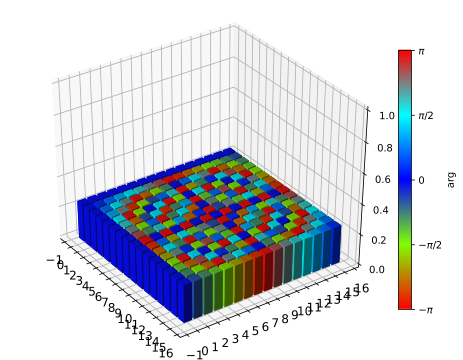

In [10]:
qft_pulse = ff.concatenate(
    (four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'][(0, 1, 2)],  # rotations on first qubit
     four_qubit_pulses['CZ_pi8-swap'][(2, 3)],                          # ... 
     four_qubit_pulses['hadamard-CZ_pi2-swap-CZ_pi4-swap'][(0, 1, 2)],  # rotations on second qubit
     four_qubit_pulses['hadamard-CZ_pi2-swap'][(0, 1)],                 # rotation on third qubit
     four_qubit_pulses['hadamard'][0]),                                 # rotation on fourth qubit
    show_progressbar=True
)

from qutip.qip.algorithms.qft import qft as qt_qft
print('Correct action:',
      ff.util.oper_equiv(qt_qft(4), qft_pulse.total_Q))
print('Trace fidelity:',
      np.trace(qt_qft(4).dag().full() @ qft_pulse.total_Q).real/2**4)
print('Filter function cached:', qft_pulse.is_cached('F'))
qt.matrix_histogram_complex(qft_pulse.total_Q)

In [11]:
import matplotlib.pyplot as plt

single_qubit_identifiers = [
    i for i in qft_pulse.n_oper_identifiers if len(i) < 4
]
two_qubit_identifiers = [
    i for i in qft_pulse.n_oper_identifiers if len(i) > 4
]
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9, 9))
_ = plotting.plot_filter_function(qft_pulse, axes=ax[0],
                                  yscale='log', omega_in_units_of_tau=False,
                                  n_oper_identifiers=single_qubit_identifiers)
_ = plotting.plot_filter_function(qft_pulse, axes=ax[1],
                                  yscale='log', omega_in_units_of_tau=False,
                                  n_oper_identifiers=two_qubit_identifiers)

for n in (1, 2, 3, 4, 6, 8):
    ax[0].axvline(n*2*np.pi/30, color='k', zorder=0, linestyle='--', alpha=0.3)
    ax[1].axvline(n*2*np.pi/30, color='k', zorder=0, linestyle='--', alpha=0.3)    

Evidently, the DC regime is dominated by the $X_3$ and $Y_3$ filter functions. This is obvious, since the third qubit idles for most of the algorithm in this circuit arrangement. In a realistic setting, the idling periods would be filled with dynamical decoupling sequences, thus cancelling most of the slow noise on the third qubit. Similarly, the $ZZ_{23}$ exchange is turned on least frequently and thus dominates the exchange filter functions.

The sharp peaks, some of which are indicated by grey dashed lines, are harmonics located at frequencies which are multiples of the inverse duration of a a single atomic pulse, $t_\mathrm{clock} = 30$, i.e. $\omega_n = 2\pi n/t_\mathrm{clock}$. Interestingly, the filter function has a baseline of around $10^4$ in the range $\omega\in[10^{-1}, 10^{1}]$ before it drops down to follow the usual $1/\omega^2$ behavior. 